# **HW3- WGAN-CP**

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import trange
from datetime import datetime
from collections import OrderedDict, Counter
from itertools import product
from prettytable import PrettyTable
import os
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import torch
import torchvision
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.autograd as autograd
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter


In [5]:
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
torch.cuda.is_available()

True

In [6]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = '/content/drive/My Drive/DL-Raja/HW3/ex3_304827702_201271509/WGAN'
os.chdir(ROOT_PATH)
os.getcwd()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


'/content/drive/My Drive/DL-Raja/HW3/ex3_304827702_201271509/WGAN'

# **Load Fashion MNIST dataset**

In [0]:
def load_FMNIST_dataset(transform, train=True):
    return torchvision.datasets.FashionMNIST(
                root = '~/.pytorch/F_MNIST_data/',
                train = train,
                download = True,
                transform = transform
            )
# each channel is normalized to be in the range [-1,1] (only one channel (grayscale))
TRANSFORM = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))] 
                                )

In [8]:
BATCH_SIZE = 32
training_set = load_FMNIST_dataset(TRANSFORM)
train_loader = torch.utils.data.DataLoader(training_set, batch_size = BATCH_SIZE, shuffle=True)

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Create random noise and real images

In [0]:
def create_noise(n_samples=8, z_dim=100, device="cpu" , fixed=False, seed=1):
    if fixed:
        torch.manual_seed(seed)
    # noise = torch.randn(n_samples, z_dim, device=device).float()
    noise = 2 * torch.rand(n_samples, z_dim, device=device).float() - 1
    return noise


#**WGAN-CP classes**

In [0]:
def create_gen_block(c_in, c_out, k, s, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(c_in, c_out, k, s, padding, bias=False),
        nn.BatchNorm2d(c_out),
        nn.ReLU(True)
        )
    
class GeneratorWGANCP(nn.Module):
    def __init__(self, z_dim=100, c_out=128, k=4, s=2, padding=1, c_in=1):
        super(GeneratorWGANCP, self).__init__()
        self.c_out = c_out
        # input is (c_in) x z_dim -> (c_out * 4) x 7 x 7
        self.fc1 = nn.Sequential(
             nn.Linear(z_dim, c_out * 4 * (7 * 7)),
             nn.ReLU(True),
        )
        # (c_out * 4) x 7 x 7 -> (c_out * 2) x 14 x 14
        self.B1 = create_gen_block(c_out * 4 ,c_out * 2, k, s, padding)
        # (c_out * 2) x 14 x 14 -> c_out x 28 x 28
        self.B2 = create_gen_block(c_out * 2, c_out, k, s, padding)
        # c_out x 28 x 28 -> 1 x 28 x 28
        self.conv = nn.Conv2d(c_out, c_in, 1, stride=1, padding=0)

    def forward(self, x):
        fc1_out = self.fc1(x)
        fc1_out = fc1_out.view(-1, 4 * self.c_out, 7, 7)
        b1_out = self.B1(fc1_out)
        b2_out = self.B2(b1_out)
        output = torch.tanh(self.conv(b2_out))
        return output


def create_critic_block(c_in, c_out, k, s, padding, p):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, k, s, padding, bias=False),
        nn.LeakyReLU(p, inplace=True),
    )


class Critic(nn.Module):
    def __init__(self, c_in=1, c_out=64, k=5, s=2, padding=2, p=0.2, h_in=28):
        super(Critic, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.h_in = h_in
        # input is (c_in) x 28 x 28 -> (c_out) x 14 x 14
        self.B1 = create_critic_block(c_in, c_out, k, s, padding, p)
        # (c_out) x 14 x 14 -> (c_out * 2) x 7 x 7
        self.B2 = create_critic_block(c_out, c_out * 2, k, s, padding, p)
        # (c_out * 2) x 7 x 7 -> (c_out * 4) x 4 x 4
        self.B3 = create_critic_block(c_out* 2, c_out * 4, k, s, padding, p)
        #  (4 * c_out) x 4 x 4 -> (4 * 4 * 4 c_out) x 1 x 1
        self.fc = nn.Linear(4 * (4 * 4) * c_out, c_in)

    def forward(self, x):
        x = x.view(-1, self.c_in, self.h_in, self.h_in)
        b1_out = self.B1(x)
        b2_out = self.B2(b1_out)
        b3_out = self.B3(b2_out)
        b3_out = b3_out.view(-1, 4 * (4 * 4) *self.c_out)
        output = self.fc(b3_out)
        # output = torch.sigmoid(self.fc(b3_out))
        return output.view(-1)
        # return output




## Hyperparameters generator

In [0]:
class HyperparamsConfig:
    def __init__(self, hyperparams_dict): 
        self.hyperparams_dict = hyperparams_dict
        self.hyperparams_names = list(hyperparams_dict.keys())

    def create_configs(self):
        h_params_names = self.hyperparams_names
        for h_params_vals in product(*[h_params  for h_params in self.hyperparams_dict.values()]):
            yield {h_params_name: h_params_vals[i] for i, h_params_name in enumerate(h_params_names)}


## Model configuration per run 
* Create  a new WGAN model acclording to specific configuration (if starting epoch=0)
* Enabing load saved model with its optimizer, scheduler and starting epoch

In [0]:
class ModelRun:
    def __init__(self, model, model_type, config, epochs, device, trained_model_path=''):
        self.config = config
        self.epochs = epochs
        self.model_name = ''
        self.device = device
        self.start_epoch = 0
        self.model = model
        self.optimizer = self.set_optimizer(model_type)
        self.scheduler = lr_scheduler.CosineAnnealingLR(self.optimizer,epochs)
        self.loss = []
        if trained_model_path != '' and os.path.exists(trained_model_path):
            self.load_model(trained_model_path)

            
    
    def set_optim_params(self, param_groups, params_dict):
        weight_decay = self.config.get('weight_decay', 0.0)
        if weight_decay > 0:
            params_dict['weight_decay'] = weight_decay
        for param_name, param_val in  params_dict.items():
            param_groups[param_name] = param_val


    def set_optimizer(self, model_type):
        model = self.model
        model.to(self.device)
        config = self.config
        optimizer_dict = config['optimizer_dict']
        optim_name = optimizer_dict['optim_name']
        self.set_model_name(optim_name, model_type)
        lr = self.config['lr']
        optimizer = optimizer_dict['optim_func'](model.parameters(), lr=lr)
        optimizer_params_dict = optimizer_dict['optim_params']
        self.set_optim_params(optimizer.param_groups[0], optimizer_params_dict)
        return optimizer


    def set_model_name(self, optim_name, model_type):
        config = self.config
        lr = config.get('lr')
        weight_decay = config.get('weight_decay', 0.0) 
        self.model_name = f"WGAN-CP_{model_type}_optimizer={optim_name}_" \
                          f"lr={lr}_weight_decay={weight_decay}"


    def get_model(self):
        return self.model
         
    def get_device(self):
        return self.device

    def get_max_grad_norm(self):
        return self.max_grad_norm

    def get_optimizer(self):
        return self.optimizer
    
    def get_scheduler(self):
        return self.scheduler

    def get_model_name(self):
        return self.model_name
    
    def get_loss(self):
        return self.loss

    def get_epochs(self):
        return self.epochs

    def get_start_epoch(self):
        return self.start_epoch
         
    def load_model(self, path_model):
        checkpoint = torch.load(path_model)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.loss = checkpoint['loss']
        self.iters = checkpoint['iters']


## Run configuration
* fit and evaluate on validation
* scalar plot (tensorboard) and train-validation plot
* enable saving the model during training

In [0]:
class RunConfig:
    def __init__(self, model_G_config, model_C_config, device, critic_iters=1, save_every=1,
                 save_model=True, folder_checkpoint=''):
        
        self.save_model = save_model
        self.save_every = save_every
        self.model_G_config = model_G_config
        self.model_C_config = model_C_config
        self.epochs = model_G_config.get_epochs()
        self.start_epoch = model_G_config.get_start_epoch()
        self.critic_iters = critic_iters
        self.device = device
        self.folder_checkpoint = folder_checkpoint

    @staticmethod
    def loss_critic(model_G, model_C, img, noise, return_fake=False): 
        img_fake = model_G(noise)
        output_real = model_C(img).mean()
        output_fake = model_C(img_fake).mean()
        loss = output_fake - output_real
        if return_fake:
            return loss, img_fake
        return loss

    @staticmethod
    def loss_generative(model_G, model_C, noise): 
        img_fake = model_G(noise)
        loss = - model_C(img_fake).mean()
        return loss



    def get_model_config(self, name):
        if name == 'G':
            return self.model_G_config
        elif name == 'C':
            return self.model_C_config

    def get_epochs(self):
        return self.epochs


    def plot_fake_imgs(self, fake_imgs, iters, folder_plot,
                       nrow=4, pad_value=1, figsize=(8,8)): # , figsize=(2,2)
        model_name = self.model_G_config.get_model_name()
        model_saved_name = model_name + f'_iters={iters+1}'
        full_path = os.path.join(folder_plot, f'fake_img_{model_saved_name}.png')
        plt.figure()  # figsize=figsize
        plt.axis("off")
        plt.title(f"Fake Images")
        plt.imshow(np.transpose(
            vutils.make_grid(fake_imgs, padding=2,normalize=True, nrow=nrow, pad_value=pad_value).cpu(), 
            (1,2,0)),
            cmap='gray')
        plt.savefig(full_path)
        plt.close()

    def save_checkpoint(self, iters, model_config):
        model_name = model_config.get_model_name()
        model_saved_name = model_name + f'_iters={iters+1}'
        full_path = os.path.join(self.folder_checkpoint,
                                 f'{model_saved_name}.pth')
        torch.save({'model_state_dict': model_config.get_model().state_dict(),
                    'optimizer_state_dict': model_config.get_optimizer().state_dict(),
                    'scheduler_state_dict': model_config.get_scheduler().state_dict(),
                    'loss': model_config.get_loss(),
                    'iters':iters+1}, full_path)
        

    def fit(self, train_loader, z_dim=100, k=1, real_label=1, w_clip=0.01,
            save_fixed_noise=True, folder_plot=''): #K = {1, 4, 5}, plot sandal
        fake_label = 1 - real_label
        model_G_config = self.model_G_config
        model_C_config = self.model_C_config
        model_G = model_G_config.get_model()
        model_C = model_C_config.get_model()
        device = self.device
        model_G = model_G.to(device)
        model_C = model_C.to(device)
        start_epoch, epochs = self.start_epoch, self.epochs
        self.w_clip = w_clip
        opt_G = model_G_config.get_optimizer()
        opt_C = model_C_config.get_optimizer()
        sched_G =  model_G_config.get_scheduler()
        sched_C =  model_C_config.get_scheduler()
        loss_C = model_C_config.get_loss()
        loss_G = model_G_config.get_loss()
        
        iters = 0
        fixed_noise = create_noise(z_dim=z_dim, device=self.device, fixed=True)
        if save_fixed_noise:
            torch.save(fixed_noise, os.path.join(FOLDER_IMGS, 'fixed_noise.pth'))
        for epoch in range(start_epoch, epochs):
            print(f'epochs {epoch +1} out of {epochs}')
            for i, (real_img, labels_img) in enumerate(train_loader):
                real_img = real_img.to(device)
                real_img_v = autograd.Variable(real_img).cuda(self.device)
                batch_size = real_img.size(0)
                opt_C.zero_grad()
                noise = create_noise(batch_size, z_dim, device=self.device)
                noise_v = autograd.Variable(noise).cuda(self.device) 
                for p in model_C.parameters():
                    p.data.clamp_(-self.w_clip, self.w_clip)
                loss_c, fake_img = self.loss_critic(model_G, model_C, real_img_v, noise_v, return_fake=True)
                loss_c.backward()
                opt_C.step()
                
                #update generator after every critic_iters's critic updates
                if (iters+1) % self.critic_iters == 0:
                    opt_G.zero_grad()
                    noise = create_noise(batch_size, z_dim, device=self.device)
                    noise_v = autograd.Variable(noise).cuda(self.device)  # totally freeze mode_G
                    loss_g = self.loss_generative(model_G, model_C, noise_v)
                    loss_g.backward()
                    opt_G.step()

                    loss_G.append(loss_g.item())
                    loss_C.append(loss_c.item())

                if self.save_model and (iters + 1) % self.save_every == 0:
                    print(f'iter = {iters+1} \nloss_C: {loss_C[-1]}\tLoss_G: {loss_G[-1]}')
                    with torch.no_grad():
                        fixed_fake_img = model_G(fixed_noise).detach()
                    
                    self.plot_fake_imgs(fixed_fake_img, iters, folder_plot)
                    self.save_checkpoint(iters, model_G_config)
                    self.save_checkpoint(iters, model_C_config)
                    
                iters += 1

            sched_C.step()
            sched_G.step()


# **Plots**
* write to tensorboard when tuning on validation set
* make plots after choosing best hyperparams and check validation

In [0]:
# writer for tuning hyperparameters (on validation set)
def plot_hyperparams(config_run, names=['Generator', 'Critic']): # start_epoch
    writer = SummaryWriter()
    model_G = config_run.get_model_config('G')
    model_C = config_run.get_model_config('C')
    loss_G = model_G.get_loss()
    loss_C = model_C.get_loss()
    models_name = f'G={model_G.get_model_name()}_C={model_C.get_model_name()}'
    epochs = len(loss_G)
    for i in range(epochs): # start_epoch
        tag_scalar_dict = {names[0]: loss_G[i], names[1]: loss_C[i]}
        writer.add_scalars(f'loss/{models_name}', tag_scalar_dict, i+1)
    writer.close()

# save plots of best models
def plot_loss(config_run, folder_plot, save_plot=False, y_label='Loss', x_label='iterations'):  # start_epoch
    dict_loss = {'Generator': config_run.get_model_config('G').get_loss(),
                 'Critic': config_run.get_model_config('C').get_loss()}
    df_loss = pd.DataFrame(dict_loss)
    df_loss.set_index(pd.Index(range(1, df_loss.shape[0] + 1)), inplace=True)
    sns.lineplot(data=df_loss)
    title = 'WGAN loss'
    plt.title(title)
    plt.ylim()
    plt.ylabel(y_label)
    plt.xlim(1,df_loss.shape[0])
    plt.xlabel(x_label)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(folder_plot,f"WGAN_loss_{datetime.now().strftime('%y%m%d_%H%M%S')}.png"))
    plt.show()

# main

In [0]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 16
FOLDER_CHECKPOINT = os.path.join(os.getcwd(), 'checkpoint')
FOLDER_PLOT = os.path.join(os.getcwd(), "plots")
FOLDER_IMGS = os.path.join(os.getcwd(), "imgs")
os.makedirs(FOLDER_CHECKPOINT,exist_ok=True)
os.makedirs(FOLDER_PLOT,exist_ok=True)
os.makedirs(FOLDER_IMGS,exist_ok=True)



def main(**args):
    torch.manual_seed(SEED)
    random.seed(SEED)
    save_model = args.get('save_model', True)
    scalar_plot = args.get('scalar_plot', False) 
    make_plot = args.get('make_plot', False) 
    save_plot = args.get('save_plot', False) 
    
    file_saved_G_model = args.get('file_saved_G_model', '')
    file_saved_C_model = args.get('file_saved_C_model', '')
    trained_model_G_path = '' if file_saved_G_model == '' else \
        os.path.join(os.getcwd(), FOLDER_CHECKPOINT, f'{file_saved_G_model}.pth')
    trained_model_C_path = '' if file_saved_C_model == '' else \
        os.path.join(os.getcwd(), FOLDER_CHECKPOINT, f'{file_saved_C_model}.pth')
    dict_G_params = args.get('dict_G_params')
    config_G_params = HyperparamsConfig(dict_G_params)
    dict_C_params = args.get('dict_C_params')
    config_C_params = HyperparamsConfig(dict_C_params)
    train_loader = args.get('train_loader')
    save_every = args.get('save_every', 125)
    critic_iters = args.get('critic_iters', 1)

    for G_config in config_G_params.create_configs():
        print(f'Generator hyperparams:\n{G_config}')
        for C_config in config_C_params.create_configs():
            print(f'Critic hyperparams:\n{C_config}')
            model_G = ModelRun(GeneratorWGANCP(), 'G', G_config, EPOCHS, DEVICE,
                                 trained_model_path=trained_model_G_path)
            model_C = ModelRun(Critic(), 'C', C_config, EPOCHS, DEVICE,
                               trained_model_path=trained_model_C_path)
            config_run = RunConfig(model_G, model_C, DEVICE, critic_iters, save_every, 
                                   save_model, FOLDER_CHECKPOINT)
            
            config_run.fit(train_loader, folder_plot=FOLDER_PLOT)
            if scalar_plot:
                plot_hyperparams(config_run)
            if make_plot:
                plot_loss(config_run, FOLDER_PLOT, save_plot)

## Run on test set with  best hyperparameter for each regularization

In [0]:
params_G_best = OrderedDict([
                      ('optimizer_dict', [{'optim_name': 'Adam', 'optim_func': optim.Adam, 'optim_params': { 'betas':(0.5, 0.999)}}]), # 'betas':(0.5, 0.999)
                      ('lr', [1e-4]), #1e-4 (best)?
                      ('weight_decay', [1e-4]) #0.0 (best)
                             ])

params_C_best =  OrderedDict([
                      ('optimizer_dict', [{'optim_name': 'Adam', 'optim_func': optim.Adam, 'optim_params': { 'betas':(0.5, 0.999)}}]), # 'betas':(0.5, 0.999)
                      ('lr', [1e-5]), #add 1e-4 (best)
                      ('weight_decay', [1e-4]) # 0.0 (Best)
                             ])

Generator hyperparams:
{'optimizer_dict': {'optim_name': 'Adam', 'optim_func': <class 'torch.optim.adam.Adam'>, 'optim_params': {'betas': (0.5, 0.999)}}, 'lr': 0.0001, 'weight_decay': 0.0001}
Critic hyperparams:
{'optimizer_dict': {'optim_name': 'Adam', 'optim_func': <class 'torch.optim.adam.Adam'>, 'optim_params': {'betas': (0.5, 0.999)}}, 'lr': 1e-05, 'weight_decay': 0.0001}
epochs 1 out of 16
iter = 125 
loss_C: -0.0267170462757349	Loss_G: 0.0015755477361381054
iter = 250 
loss_C: 0.0030746981501579285	Loss_G: -0.019630959257483482
iter = 375 
loss_C: 0.0016135554760694504	Loss_G: -0.011467022821307182
iter = 500 
loss_C: 0.0006129732355475426	Loss_G: -0.00754148093983531
iter = 625 
loss_C: -6.618723273277283e-05	Loss_G: -0.006754737813025713
iter = 750 
loss_C: -5.389843136072159e-05	Loss_G: -0.006171700078994036
iter = 875 
loss_C: -0.00030926335602998734	Loss_G: -0.006360792089253664
iter = 1000 
loss_C: 0.00015052687376737595	Loss_G: -0.007477982435375452
iter = 1125 
loss_C: 0

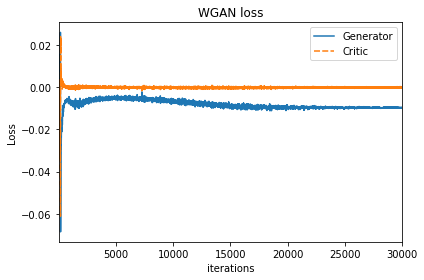

In [17]:
#take best hyperparams and run on test
main(dict_G_params=params_G_best, dict_C_params=params_C_best,
     train_loader=train_loader, make_plot=True, save_plot=True)

### Save real imges (for plot)

In [0]:
def get_real_imgs(data_loader, class_labels):
    imgs, labels = iter(data_loader).next()
    real_imgs = []
    for class_label in class_labels:
        img = imgs[labels == class_label][0]
        real_imgs.append(img.cpu().numpy())
    
    return real_imgs

BATCH_SIZE_TEST = 10000
test_set = load_FMNIST_dataset(TRANSFORM, train=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = BATCH_SIZE_TEST, shuffle=False)
class_labels = [4, 7]
real_images = get_real_imgs(test_loader, class_labels)

np.savez_compressed(os.path.join(FOLDER_IMGS, 'real_imgs.npz'), img1=real_images[0],
                    img2=real_images[1])

## Test pre-trained model
* load Generator
* load real images and noise samples
* print results



In [0]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 16
FOLDER_MODEL = os.path.join(os.getcwd(), FOLDER_CHECKPOINT)
FOLDER_PLOT = os.path.join(os.getcwd(), "plots")
FOLDER_IMGS = os.path.join(os.getcwd(), "imgs")

def load_tensor(path_folder, file_name='fixed_noise', sfx='pth'):
    obj = torch.load(os.path.join(path_folder, f'{file_name}.{sfx}'))
    return obj
    

def load_np(objs_name, path_folder, file_name='real_imgs', sfx='npz'):
    loaded = np.load(os.path.join(path_folder, f'{file_name}.{sfx}'))
    objs = []
    for obj_name in objs_name:
        objs.append(loaded[obj_name])
    return objs


def plot_imgs(imgs_real, imgs_fake, figsize=(25, 4), pad_value=1, save_plot=False,
              folder_plot=None):
    
    fig = plt.figure() # figsize=figsize
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title(f"Fake Images")
    plt.imshow(np.transpose(
            vutils.make_grid(imgs_fake, padding=2,normalize=True, pad_value=pad_value).cpu(), 
            (1,2,0)),
            cmap='gray')

    # Plot the fake images from the last iters
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title(f"Real Images")
    plt.imshow(np.transpose(
            vutils.make_grid(imgs_real, padding=2,normalize=True, pad_value=pad_value).cpu(), 
            (1,2,0)),
            cmap='gray')
    if not save_plot:
        plt.show()
    else:
        plt.savefig(os.path.join(folder_plot,f"WGAN_imgs_{datetime.now().strftime('%y%m%d_%H%M%S')}.png"))
        plt.close()


def get_generated_img(**args): 
    file_saved_G_model = args.get('file_saved_G_model', '')
    trained_model_G_path = os.path.join(FOLDER_MODEL, f'{file_saved_G_model}.pth')
    model_G_params = args.get('model_G_params')
    fixed_noise = load_tensor(FOLDER_IMGS)
    objs_name = args.get('objs_name', ['img1', 'img2'])
    img_idxes = args.get('img_idxes', [])
    save_plot = args.get('save_plot', True)
    model_G = ModelRun(GeneratorWGANCP(), 'G', model_G_params, EPOCHS, DEVICE,
                            trained_model_G_path)
    model_pretrained_G = model_G.get_model()
    with torch.no_grad():
        model_pretrained_G.eval()
        fixed_fake_img = model_pretrained_G(fixed_noise)[img_idxes].detach()  
    
    real_imgs = load_np(objs_name, FOLDER_IMGS)
    real_imgs = np.expand_dims(np.concatenate(real_imgs), 1)
    real_imgs = torch.from_numpy(real_imgs).float()
    plot_imgs(real_imgs, fixed_fake_img, figsize=(4, 4), save_plot=save_plot,
              folder_plot=FOLDER_PLOT)

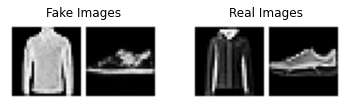

In [26]:
params_G_best = OrderedDict([
                      ('optimizer_dict', {'optim_name': 'Adam', 'optim_func': optim.Adam, 'optim_params': { 'betas':(0.5, 0.999)}}),
                      ('lr', 0.0001), #add 0.0005 (best)?
                      ('weight_decay', 1e-4) #0.0 (best)
                             ])
file_saved_G_model = 'WGAN-CP_G_optimizer=Adam_lr=0.0001_weight_decay=0.0001_iters=30000'

img_idxes = [4, 7] #add two
get_generated_img(file_saved_G_model=file_saved_G_model, model_G_params=params_G_best,
                  img_idxes=img_idxes)
get_generated_img(file_saved_G_model=file_saved_G_model, model_G_params=params_G_best, 
                  img_idxes=img_idxes, save_plot=False)